In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from reComBat import reComBat


In [2]:
technology = "microarray" # "RNAseq"
#technology = "RNAseq" #microarray

In [3]:

# Assuming your DataFrame is called cts and has gene expression data
# Assuming cts is a pandas DataFrame with gene expression data
if technology == "microarray":
    cts = pd.read_csv("/home/karen/Documents/phd/Data/trainign_dataset_51270_microarray_unadjusted.csv")
elif technology == "RNAseq":
    cts = pd.read_csv("/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/RNAseq_All_abundances_unadjusted.csv")

metadata =   cts[["Experiment", "Sample", "Age"]]


/tmp/ipykernel_45066/3142307427.py:4: DtypeWarning: Columns (51280) have mixed types. Specify dtype option on import or set low_memory=False.
  cts = pd.read_csv("/home/karen/Documents/phd/Data/trainign_dataset_51270_microarray_unadjusted.csv")


In [4]:
metadata

,Experiment,Sample,Age
0,GSE13070,GSM342608,52.50
1,GSE13070,GSM342609,50.60
2,GSE13070,GSM342610,56.08
3,GSE13070,GSM342611,54.84
4,GSE13070,GSM342614,51.14
...,...,...,...
772,GSE9676,GSM244612,65.10
773,GSE9676,GSM244613,68.40
774,GSE9676,GSM244614,65.90
775,GSE9676,GSM244615,67.30


# Function

In [5]:
import matplotlib.pyplot as plt

def generate_colors(n):
        colormap = plt.cm.get_cmap('tab20', n)
        colors = [colormap(i) for i in range(n)]
        return colors
    
def blot_expression(subset_data, experiments, count_experiments, colors=None, title=None, save=False):
    
    if colors is None:
        colors = generate_colors(len(experiments))
    colored = np.sum(list(count_experiments.values()))
    if len(subset_data.columns) != colored:
        raise "the columns and the experiments should be same length"
        return None
    if len(count_experiments) != len(experiments):
        raise "the count_experiments and the experiments should be same length"
        return None
    if title is None:
        title = 'Expression of Gene Expression Across Experiments'
    boxes=[]
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    start_c = 0
    end_c = len(subset_data.columns)
    color_i = 0
    for exp in experiments:
        end_c=start_c + count_experiments[exp]
        # Boxplot for the first 84 columns
        box= ax.boxplot(subset_data.iloc[:, start_c:end_c], positions=list(range(start_c+1,end_c+1)), showfliers=False, patch_artist=True,
                          boxprops=dict(facecolor=colors[color_i], color=colors[color_i])
                          )
        start_c = end_c
        boxes.append(box)
        color_i=color_i+1
                          
    
    # Set labels and titles
    ax.set_title(title)
    ax.set_ylabel('Expression')
    
    # Adjust legend
    legends_list = [b["boxes"][0] for b in boxes]
    ax.legend(legends_list, experiments)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

def two_step_normalization( data: pd.DataFrame):
        """
        Two step normalization from Ivan Izonin et al, 2022.  Two-Step Data Normalization Approach for Improving 
        Classification Accuracy in the Medical Diagnosis Domain.
        1. Max Abs Scaler
        2. L2 normalization
        3. Add norm feature
        4. L2 normalization
        5. Return the normalized dataset
        """
        dataset = data.values
        # Initialize the Max Abs Scaler (step 1)
        scaler = MaxAbsScaler()

        # Fit and transform the data Equation (1)
        dataset = scaler.fit_transform(dataset)
        # Calculate the norm of each vector in the dataset using Equation (2)
        norms = np.sqrt(np.sum(dataset ** 2, axis=1))
        # Apply Equation (3) to calculate the norm of each vector in the dataset
        dataset = np.divide(dataset, norms[:, np.newaxis])
        # add norm feature
        dataset = np.column_stack((dataset, norms))

        
        # let's repeat the scaler
        scaler_2 = StandardScaler()
        dataset = scaler_2.fit_transform(dataset)

        # dataset = np.delete(dataset, -1, axis=1)
        # transform back to dataframe and return
        columns = list(data.columns)
        columns.append('norm')
        return pd.DataFrame(dataset, index=data.index, columns=columns)
    


In [6]:
cts

,Sample,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,...,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Sex,Age,Status
0,GSM342608,870.599976,500.399994,165.000000,900.900024,67.400002,346.600006,255.300003,58.000000,70.800003,...,341.000000,2384.300049,101.699997,59.500000,159.399994,233.000000,GSE13070,Male,52.50,IRd
1,GSM342609,1635.300049,390.899994,252.199997,795.000000,108.300003,623.000000,260.500000,76.400002,4.200000,...,292.399994,3852.000000,70.699997,32.700001,155.899994,383.200012,GSE13070,Male,50.60,IRd
2,GSM342610,1006.799988,383.200012,198.199997,924.000000,129.399994,649.599976,192.800003,40.700001,16.200001,...,263.799988,2043.599976,165.000000,94.099998,220.100006,399.100006,GSE13070,Male,56.08,IRd � TZD
3,GSM342611,1215.800049,496.200012,160.600006,500.899994,18.799999,345.299988,257.600006,23.400000,41.500000,...,238.100006,2176.800049,93.599998,21.799999,183.899994,483.899994,GSE13070,Male,54.84,IRd � TZD
4,GSM342614,823.599976,561.500000,305.500000,1214.099976,81.300003,494.399994,208.199997,63.799999,79.199997,...,223.899994,2341.699951,142.600006,79.699997,341.299988,397.399994,GSE13070,Male,51.14,IRd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,GSM244612,1316.250000,1582.450000,11268.600000,7065.080000,6376.640000,1996.200000,10128.300000,7015.010000,235.884000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.10,NaN
773,GSM244613,966.504000,889.863000,9753.840000,4753.410000,6072.460000,1229.210000,6264.000000,5658.760000,335.332000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,68.40,NaN
774,GSM244614,1382.900000,1278.390000,11248.800000,7119.220000,6891.120000,1431.700000,8131.630000,6416.350000,432.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.90,NaN
775,GSM244615,1498.540000,1276.440000,10965.900000,6940.470000,7879.880000,1917.330000,7469.210000,6153.410000,440.064000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,67.30,NaN


In [7]:
sample_order = cts["Sample"].tolist()  # Get the order of samples in cts
experiment_order = cts["Experiment"].tolist() 
age_order = cts["Age"].tolist()


In [8]:
df =pd.DataFrame(experiment_order)
count_experiments = dict(df[0].value_counts())
count_experiments
experiments = list(count_experiments)
experiments

['GSE13070',
 'GSE47969',
 'GSE48278',
 'GSE9103',
 'GSE59880',
 'GSE9676',
 'GSE161643',
 'GSE8157',
 'GSE1428',
 'GSE38718',
 'GSE6348',
 'GSE40551',
 'GSE87105',
 'GSE674_2']

In [9]:
def map_to_category(age):
    if age <= 35:
        return "Young"
    elif age > 65:
        return "Old"
    else:
        return "MiddleAge"

# Map values in age_order to categories
age_order = [map_to_category(age) for age in age_order]

In [10]:
cts

,Sample,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,...,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Sex,Age,Status
0,GSM342608,870.599976,500.399994,165.000000,900.900024,67.400002,346.600006,255.300003,58.000000,70.800003,...,341.000000,2384.300049,101.699997,59.500000,159.399994,233.000000,GSE13070,Male,52.50,IRd
1,GSM342609,1635.300049,390.899994,252.199997,795.000000,108.300003,623.000000,260.500000,76.400002,4.200000,...,292.399994,3852.000000,70.699997,32.700001,155.899994,383.200012,GSE13070,Male,50.60,IRd
2,GSM342610,1006.799988,383.200012,198.199997,924.000000,129.399994,649.599976,192.800003,40.700001,16.200001,...,263.799988,2043.599976,165.000000,94.099998,220.100006,399.100006,GSE13070,Male,56.08,IRd � TZD
3,GSM342611,1215.800049,496.200012,160.600006,500.899994,18.799999,345.299988,257.600006,23.400000,41.500000,...,238.100006,2176.800049,93.599998,21.799999,183.899994,483.899994,GSE13070,Male,54.84,IRd � TZD
4,GSM342614,823.599976,561.500000,305.500000,1214.099976,81.300003,494.399994,208.199997,63.799999,79.199997,...,223.899994,2341.699951,142.600006,79.699997,341.299988,397.399994,GSE13070,Male,51.14,IRd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,GSM244612,1316.250000,1582.450000,11268.600000,7065.080000,6376.640000,1996.200000,10128.300000,7015.010000,235.884000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.10,NaN
773,GSM244613,966.504000,889.863000,9753.840000,4753.410000,6072.460000,1229.210000,6264.000000,5658.760000,335.332000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,68.40,NaN
774,GSM244614,1382.900000,1278.390000,11248.800000,7119.220000,6891.120000,1431.700000,8131.630000,6416.350000,432.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.90,NaN
775,GSM244615,1498.540000,1276.440000,10965.900000,6940.470000,7879.880000,1917.330000,7469.210000,6153.410000,440.064000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,67.30,NaN


In [11]:



cts_processed = cts.copy()

if technology == "microarray":
    cts_processed.drop(['Age', 'Sex', 'Status', 'Experiment'], axis=1, inplace=True)
elif technology == "RNAseq":
    cts_processed.drop(['Age', 'Sample.1', 'Experiment'], axis=1, inplace=True)

samples=cts_processed["Sample"]
cts_processed.set_index("Sample",  inplace=True)
gene_columns= cts_processed.columns


In [12]:
data = cts_processed.T
data

Sample,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,870.599976,1635.300049,1006.799988,1215.800049,823.599976,1174.000000,871.799988,1531.000000,837.700012,1026.400024,...,893.719,1307.66,1167.92,962.987,1098.29,1316.25,966.504,1382.90,1498.54,1127.14
M87338,500.399994,390.899994,383.200012,496.200012,561.500000,544.400024,511.100006,409.700012,352.100006,604.299988,...,1195.870,1416.94,1721.65,1196.380,1544.92,1582.45,889.863,1278.39,1276.44,1247.63
X51757,165.000000,252.199997,198.199997,160.600006,305.500000,239.899994,273.600006,121.099998,140.500000,211.600006,...,10278.600,10395.10,10960.90,11494.600,12586.50,11268.60,9753.840,11248.80,10965.90,11196.30
X69699,900.900024,795.000000,924.000000,500.899994,1214.099976,609.299988,531.000000,652.599976,821.000000,570.700012,...,5435.160,6138.75,8321.32,8694.850,7740.13,7065.08,4753.410,7119.22,6940.47,4809.99
L36861,67.400002,108.300003,129.399994,18.799999,81.300003,9.600000,83.300003,17.200001,12.900000,81.500000,...,6007.200,7298.46,6727.35,6784.570,6309.06,6376.64,6072.460,6891.12,7879.88,6443.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,2384.300049,3852.000000,2043.599976,2176.800049,2341.699951,3027.199951,2351.600098,2876.600098,2640.500000,2613.000000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
C18318,101.699997,70.699997,165.000000,93.599998,142.600006,111.800003,12.000000,146.100006,101.199997,64.500000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI219073,59.500000,32.700001,94.099998,21.799999,79.699997,46.400002,34.299999,58.799999,15.000000,109.800003,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI205180,159.399994,155.899994,220.100006,183.899994,341.299988,371.600006,311.200012,347.899994,517.200012,303.799988,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00


In [13]:
cts_processed.columns

Index(['U48705', 'M87338', 'X51757', 'X69699', 'L36861', 'L13852', 'X55005',
       'X79510', 'M21121', 'J02843',
       ...
       'AW050627', 'AI654857', 'W22117', 'AI028241', 'AI571298', 'AA149545',
       'C18318', 'AI219073', 'AI205180', 'AI363375'],
      dtype='object', length=51276)

In [14]:
#!pip install combat

In [15]:
experiment_order= pd.Series(experiment_order)


In [16]:
experiment_order

0      GSE13070
1      GSE13070
2      GSE13070
3      GSE13070
4      GSE13070
         ...   
772     GSE9676
773     GSE9676
774     GSE9676
775     GSE9676
776     GSE9676
Length: 777, dtype: object

In [17]:
data

Sample,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,870.599976,1635.300049,1006.799988,1215.800049,823.599976,1174.000000,871.799988,1531.000000,837.700012,1026.400024,...,893.719,1307.66,1167.92,962.987,1098.29,1316.25,966.504,1382.90,1498.54,1127.14
M87338,500.399994,390.899994,383.200012,496.200012,561.500000,544.400024,511.100006,409.700012,352.100006,604.299988,...,1195.870,1416.94,1721.65,1196.380,1544.92,1582.45,889.863,1278.39,1276.44,1247.63
X51757,165.000000,252.199997,198.199997,160.600006,305.500000,239.899994,273.600006,121.099998,140.500000,211.600006,...,10278.600,10395.10,10960.90,11494.600,12586.50,11268.60,9753.840,11248.80,10965.90,11196.30
X69699,900.900024,795.000000,924.000000,500.899994,1214.099976,609.299988,531.000000,652.599976,821.000000,570.700012,...,5435.160,6138.75,8321.32,8694.850,7740.13,7065.08,4753.410,7119.22,6940.47,4809.99
L36861,67.400002,108.300003,129.399994,18.799999,81.300003,9.600000,83.300003,17.200001,12.900000,81.500000,...,6007.200,7298.46,6727.35,6784.570,6309.06,6376.64,6072.460,6891.12,7879.88,6443.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,2384.300049,3852.000000,2043.599976,2176.800049,2341.699951,3027.199951,2351.600098,2876.600098,2640.500000,2613.000000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
C18318,101.699997,70.699997,165.000000,93.599998,142.600006,111.800003,12.000000,146.100006,101.199997,64.500000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI219073,59.500000,32.700001,94.099998,21.799999,79.699997,46.400002,34.299999,58.799999,15.000000,109.800003,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI205180,159.399994,155.899994,220.100006,183.899994,341.299988,371.600006,311.200012,347.899994,517.200012,303.799988,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00


In [18]:
filtered_data = data[(data == 0).all(axis=1)]
data = data.drop(filtered_data.index)
data

Sample,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,870.599976,1635.300049,1006.799988,1215.800049,823.599976,1174.000000,871.799988,1531.000000,837.700012,1026.400024,...,893.719,1307.66,1167.92,962.987,1098.29,1316.25,966.504,1382.90,1498.54,1127.14
M87338,500.399994,390.899994,383.200012,496.200012,561.500000,544.400024,511.100006,409.700012,352.100006,604.299988,...,1195.870,1416.94,1721.65,1196.380,1544.92,1582.45,889.863,1278.39,1276.44,1247.63
X51757,165.000000,252.199997,198.199997,160.600006,305.500000,239.899994,273.600006,121.099998,140.500000,211.600006,...,10278.600,10395.10,10960.90,11494.600,12586.50,11268.60,9753.840,11248.80,10965.90,11196.30
X69699,900.900024,795.000000,924.000000,500.899994,1214.099976,609.299988,531.000000,652.599976,821.000000,570.700012,...,5435.160,6138.75,8321.32,8694.850,7740.13,7065.08,4753.410,7119.22,6940.47,4809.99
L36861,67.400002,108.300003,129.399994,18.799999,81.300003,9.600000,83.300003,17.200001,12.900000,81.500000,...,6007.200,7298.46,6727.35,6784.570,6309.06,6376.64,6072.460,6891.12,7879.88,6443.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,2384.300049,3852.000000,2043.599976,2176.800049,2341.699951,3027.199951,2351.600098,2876.600098,2640.500000,2613.000000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
C18318,101.699997,70.699997,165.000000,93.599998,142.600006,111.800003,12.000000,146.100006,101.199997,64.500000,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI219073,59.500000,32.700001,94.099998,21.799999,79.699997,46.400002,34.299999,58.799999,15.000000,109.800003,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00
AI205180,159.399994,155.899994,220.100006,183.899994,341.299988,371.600006,311.200012,347.899994,517.200012,303.799988,...,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00


In [19]:

data = two_step_normalization(data.T)
data.drop(columns=["norm"], inplace=True)



In [20]:

data=data.T
data


Sample,GSM342608,GSM342609,GSM342610,GSM342611,GSM342614,GSM342615,GSM342616,GSM342617,GSM342620,GSM342621,...,GSM244607,GSM244608,GSM244609,GSM244610,GSM244611,GSM244612,GSM244613,GSM244614,GSM244615,GSM244616
U48705,-0.297180,-0.051121,-0.252214,-0.179713,-0.324220,-0.196338,-0.288357,-0.091228,-0.292642,-0.235518,...,1.349448,1.798173,1.612441,1.396945,1.576923,1.973101,1.475983,2.033832,1.966616,1.635034
M87338,-0.182937,-0.226303,-0.235101,-0.174421,-0.168625,-0.153526,-0.169942,-0.220530,-0.243195,-0.119029,...,3.660831,3.664089,4.696823,3.463577,4.382673,4.448237,2.575072,3.413587,3.020723,3.462607
X51757,-0.237906,-0.231740,-0.235618,-0.237730,-0.230150,-0.232704,-0.230535,-0.240455,-0.238933,-0.234288,...,4.417314,3.737207,4.085249,4.714864,4.956631,4.363251,4.118005,4.238622,3.683360,4.386324
X69699,-0.211709,-0.219484,-0.207457,-0.253331,-0.184496,-0.241581,-0.250557,-0.237179,-0.215294,-0.244801,...,4.030670,3.830937,5.478752,6.295907,5.321865,4.777202,3.433660,4.686407,4.068144,3.192909
L36861,-0.242486,-0.236915,-0.234668,-0.248305,-0.241334,-0.249489,-0.240213,-0.248547,-0.249036,-0.240245,...,5.052466,5.191489,4.922145,5.446688,4.823453,4.824548,5.036078,5.095194,5.243932,4.936455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AA149545,0.854325,2.160857,0.610010,0.766862,0.718306,1.448616,0.890245,1.307494,1.180004,1.146341,...,-1.046166,-1.046166,-1.046166,-1.046166,-1.046166,-1.046166,-1.046166,-1.046166,-1.046166,-1.046166
C18318,0.361689,-0.121307,1.507221,0.294131,0.935710,0.602589,-1.186885,1.198754,0.454296,-0.224461,...,-1.401854,-1.401854,-1.401854,-1.401854,-1.401854,-1.401854,-1.401854,-1.401854,-1.401854,-1.401854
AI219073,-0.555322,-0.872802,-0.102184,-1.015306,-0.356877,-0.699704,-0.856782,-0.544571,-1.101908,0.147219,...,-1.300649,-1.300649,-1.300649,-1.300649,-1.300649,-1.300649,-1.300649,-1.300649,-1.300649,-1.300649
AI205180,-0.683317,-0.665822,-0.355738,-0.516633,0.147241,0.460495,0.141407,0.322687,1.289050,0.132826,...,-1.494349,-1.494349,-1.494349,-1.494349,-1.494349,-1.494349,-1.494349,-1.494349,-1.494349,-1.494349


In [21]:
data.fillna(0, inplace=True)

In [22]:
experiment_order

0      GSE13070
1      GSE13070
2      GSE13070
3      GSE13070
4      GSE13070
         ...   
772     GSE9676
773     GSE9676
774     GSE9676
775     GSE9676
776     GSE9676
Length: 777, dtype: object

In [23]:
combat = reComBat()
combat.fit(data.T,experiment_order)
data_corrected = combat.transform(data.T,experiment_order)

[reComBat] 2024-05-13 11:22:18,544 Starting to fot reComBat.
[reComBat] 2024-05-13 11:22:18,582 Fit the linear model.
[reComBat] 2024-05-13 11:22:24,904 Starting the empirical parametric optimisation.
/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/reComBat-main/reComBat/utils.py:83: RuntimeWarning: divide by zero encountered in divide
  np.max(np.abs(delta_star_squared_new_i-delta_star_squared_i)/delta_star_squared_i)])
[reComBat] 2024-05-13 11:22:25,819 Optimisation finished.
[reComBat] 2024-05-13 11:22:25,819 reComBat is fitted.
[reComBat] 2024-05-13 11:22:25,824 Starting to transform.
[reComBat] 2024-05-13 11:22:27,972 Transform finished.


In [24]:
data_corrected.index



Index(['GSM342608', 'GSM342609', 'GSM342610', 'GSM342611', 'GSM342614',
       'GSM342615', 'GSM342616', 'GSM342617', 'GSM342620', 'GSM342621',
       ...
       'GSM244607', 'GSM244608', 'GSM244609', 'GSM244610', 'GSM244611',
       'GSM244612', 'GSM244613', 'GSM244614', 'GSM244615', 'GSM244616'],
      dtype='object', name='Sample', length=777)

In [25]:
metadata.columns

Index(['Experiment', 'Sample', 'Age'], dtype='object')

In [26]:
data_corrected

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AW050627,AI654857,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375
Sample,,,,,,,,,,,,,,,,,,,,,
GSM342608,-0.936345,0.015225,-0.028562,-0.019885,0.006741,-0.435788,-0.013205,-0.042681,0.001134,0.077323,...,0.968997,0.803325,-0.778901,-0.755246,0.417180,-0.383551,0.309619,-0.000230,-0.836801,-1.325908
GSM342609,0.516161,-0.360085,0.031108,-0.089836,0.060816,0.943246,0.000147,-0.015349,-0.562068,0.196182,...,-0.652777,-0.140426,1.074347,0.412788,0.089997,1.396052,-0.265240,-0.563873,-0.820670,0.330207
GSM342610,-0.670909,-0.436229,-0.006424,0.018364,0.082632,0.987415,-0.060334,-0.063517,-0.459591,-0.297833,...,-0.522532,-1.541402,-0.562157,0.610976,-0.252021,-0.716328,1.673020,0.804256,-0.534760,0.384888
GSM342611,-0.242927,0.088927,-0.026856,-0.394352,-0.049742,-0.371358,-0.002177,-0.084742,-0.231531,-0.052484,...,-1.606666,-0.698388,2.140038,0.265120,-0.430561,-0.502683,0.229212,-0.816870,-0.683112,1.373652
GSM342614,-1.095967,0.139090,0.046489,0.224945,0.017923,0.111814,-0.059706,-0.039783,0.035643,-0.037101,...,3.125171,0.677197,-0.936273,0.216959,-0.772001,-0.568819,0.992813,0.352083,-0.070993,0.086777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,1.409118,0.642580,-0.390609,0.210783,0.367824,2.934954,0.886791,1.740655,-1.543886,2.465915,...,-0.001093,-0.001641,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385
GSM244613,-0.863118,-2.029984,-0.785770,-1.249532,0.707690,-0.236247,-1.335429,0.486263,-0.889848,0.311594,...,-0.001093,-0.001641,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385
GSM244614,1.686705,-0.833622,-0.591422,0.112096,0.802670,0.011357,-0.607074,0.583635,-0.615088,1.113347,...,-0.001093,-0.001641,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385


In [27]:
colors=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

In [28]:

#blot_expression(data, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_unalteraded__reCombat_double_norm.png")



In [29]:
# with standar norm
data_corrected

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AW050627,AI654857,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375
Sample,,,,,,,,,,,,,,,,,,,,,
GSM342608,-0.936345,0.015225,-0.028562,-0.019885,0.006741,-0.435788,-0.013205,-0.042681,0.001134,0.077323,...,0.968997,0.803325,-0.778901,-0.755246,0.417180,-0.383551,0.309619,-0.000230,-0.836801,-1.325908
GSM342609,0.516161,-0.360085,0.031108,-0.089836,0.060816,0.943246,0.000147,-0.015349,-0.562068,0.196182,...,-0.652777,-0.140426,1.074347,0.412788,0.089997,1.396052,-0.265240,-0.563873,-0.820670,0.330207
GSM342610,-0.670909,-0.436229,-0.006424,0.018364,0.082632,0.987415,-0.060334,-0.063517,-0.459591,-0.297833,...,-0.522532,-1.541402,-0.562157,0.610976,-0.252021,-0.716328,1.673020,0.804256,-0.534760,0.384888
GSM342611,-0.242927,0.088927,-0.026856,-0.394352,-0.049742,-0.371358,-0.002177,-0.084742,-0.231531,-0.052484,...,-1.606666,-0.698388,2.140038,0.265120,-0.430561,-0.502683,0.229212,-0.816870,-0.683112,1.373652
GSM342614,-1.095967,0.139090,0.046489,0.224945,0.017923,0.111814,-0.059706,-0.039783,0.035643,-0.037101,...,3.125171,0.677197,-0.936273,0.216959,-0.772001,-0.568819,0.992813,0.352083,-0.070993,0.086777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,1.409118,0.642580,-0.390609,0.210783,0.367824,2.934954,0.886791,1.740655,-1.543886,2.465915,...,-0.001093,-0.001641,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385
GSM244613,-0.863118,-2.029984,-0.785770,-1.249532,0.707690,-0.236247,-1.335429,0.486263,-0.889848,0.311594,...,-0.001093,-0.001641,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385
GSM244614,1.686705,-0.833622,-0.591422,0.112096,0.802670,0.011357,-0.607074,0.583635,-0.615088,1.113347,...,-0.001093,-0.001641,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385


In [30]:
data_corrected = data_corrected.T

In [31]:
#blot_expression(data_corrected, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_adjusted_reCombat_double_norm.png")

In [32]:
data_corrected = data_corrected.T


In [33]:
#blot_expression(data_corrected, experiments, count_experiments, colors=["blue", "green", "orange", "pink","red","purple"])

# Testing batch correction

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Set significance threshold (alpha level)

def plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05):
    # Plot histograms of p-values before and after batch correction
    plt.figure(figsize=(10, 5))
    plt.hist(p_values_before, bins=50, color='blue', alpha=0.5, label='Before Correction')
    plt.hist(p_values_after, bins=50, color='green', alpha=0.5, label='After Correction')
    plt.axvline(alpha, color='red', linestyle='--', label='Significance Threshold')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of p-values before and after batch correction')
    plt.legend()
    plt.show()
    
    # Perform Kolmogorov-Smirnov test to compare distributions of p-values
    ks_stat, ks_p_value = ks_2samp(p_values_before, p_values_after)
    print("Kolmogorov-Smirnov test p-value:", ks_p_value)
    
    # Check if more p-values fall below the significance threshold after batch correction
    num_sig_before = np.sum(p_values_before < alpha)
    num_sig_after = np.sum(p_values_after < alpha)
    
    print("Number of significant p-values before correction:", num_sig_before)
    print("Number of significant p-values after correction:", num_sig_after)

def see_distribution(p_values_before, p_values_after):

    # Plot histograms of p-values before and after batch correction
    plt.figure(figsize=(10, 5))
    sns.histplot(p_values_before, bins=50, color='blue', kde=True, label='Before Correction')
    sns.histplot(p_values_after, bins=50, color='green', kde=True, label='After Correction')
    plt.axvline(alpha, color='red', linestyle='--', label='Significance Threshold')
    plt.xlabel('p-value')
    plt.ylabel('Density')
    plt.title('Distribution of p-values before and after batch correction')
    plt.legend()
    plt.show()


In [35]:
def get_ks_values_before_after(data, data_corrected, experiment_1, experiment_2):
    data_before = data.copy()
    data_before = data_before.T
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    ks_stat_before, ks_p_value_before = ks_2samp(group_a_samples_before, group_b_samples_before)

    data_corrected.reset_index(drop=True, inplace=True)

    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    _, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    ks_stat_after, ks_p_value_after = ks_2samp(group_a_samples_corrected, group_b_samples_corrected)

    return ks_p_value_before, ks_p_value_after




In [36]:
def get_p_values_before_after(data, data_corrected, experiment_1, experiment_2):
    data_before = data.copy()
    data_before = data_before.T
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)

    data_corrected.reset_index(drop=True, inplace=True)

    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    _, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)

    return p_values_before, p_values_after

In [37]:
experiment_list = experiments
experiments

['GSE13070',
 'GSE47969',
 'GSE48278',
 'GSE9103',
 'GSE59880',
 'GSE9676',
 'GSE161643',
 'GSE8157',
 'GSE1428',
 'GSE38718',
 'GSE6348',
 'GSE40551',
 'GSE87105',
 'GSE674_2']

In [38]:
experiment_1 = experiments[5]
experiment_2 = experiments[1]

In [39]:
p_values_before, p_values_after = get_p_values_before_after(data, data_corrected, experiment_1, experiment_2)

/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [40]:
p_values_before

array([5.34584375e-149, 4.00000840e-115, 4.64851775e-131, ...,
       7.61312468e-176, 1.80418447e-200, 4.17260730e-178])

In [41]:
p_values_after

array([0.92318748, 0.53990361, 0.47024163, ..., 0.99060934, 0.99404867,
       0.99463582])

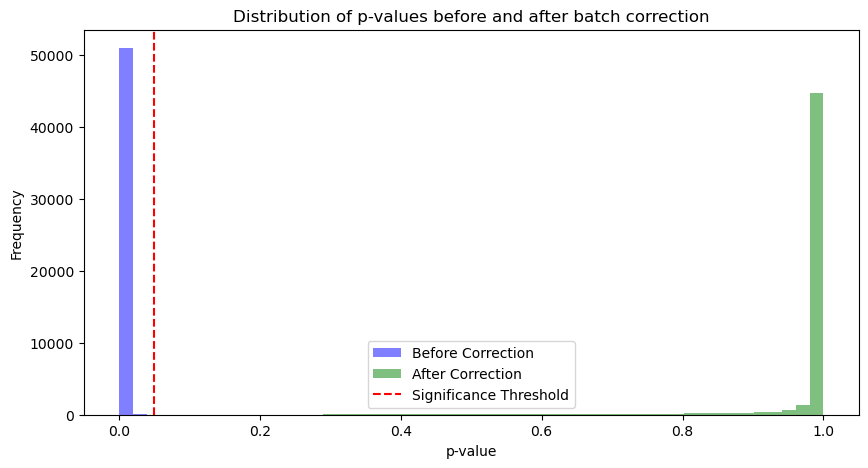

Kolmogorov-Smirnov test p-value: 0.0
Number of significant p-values before correction: 51037
Number of significant p-values after correction: 25


In [42]:
plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


In [43]:
p_values_after

array([0.92318748, 0.53990361, 0.47024163, ..., 0.99060934, 0.99404867,
       0.99463582])

## Getting all the experiments p_values


In [44]:
import itertools


In [45]:
expriments_pvalue_before=[]
expriments_pvalue_after=[]
combination_list = []
ks_stats =  []

for experiment_1, experiment_2 in itertools.combinations(experiment_list, 2):
    c = f"{experiment_1}-{experiment_2}"
    combination_list.append(c)
    print(c)
    #print("get_p_values_before_after")
    p_values_before, p_values_after = get_p_values_before_after(data, data_corrected, experiment_1, experiment_2)
    expriments_pvalue_before.append(p_values_before)
    expriments_pvalue_after.append(p_values_after)
    #print("ks_2samp")
    ks_stat, ks_p_value = ks_2samp(p_values_before, p_values_after)
    ks_stats.append({"combination":f"{experiment_1}-{experiment_2}","ks_stat":ks_stat, "ks_pvalue": ks_p_value})



GSE13070-GSE47969
GSE13070-GSE48278
GSE13070-GSE9103
GSE13070-GSE59880
GSE13070-GSE9676


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE13070-GSE161643
GSE13070-GSE8157
GSE13070-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE13070-GSE38718
GSE13070-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE13070-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE13070-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE13070-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE47969-GSE48278
GSE47969-GSE9103
GSE47969-GSE59880
GSE47969-GSE9676


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE47969-GSE161643
GSE47969-GSE8157
GSE47969-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE47969-GSE38718
GSE47969-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE47969-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE47969-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE47969-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE48278-GSE9103
GSE48278-GSE59880
GSE48278-GSE9676


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE48278-GSE161643
GSE48278-GSE8157
GSE48278-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE48278-GSE38718
GSE48278-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE48278-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE48278-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE48278-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9103-GSE59880
GSE9103-GSE9676


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9103-GSE161643
GSE9103-GSE8157
GSE9103-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9103-GSE38718
GSE9103-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9103-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9103-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9103-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE59880-GSE9676


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE59880-GSE161643
GSE59880-GSE8157
GSE59880-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE59880-GSE38718
GSE59880-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE59880-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE59880-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE59880-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9676-GSE161643
GSE9676-GSE8157


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9676-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9676-GSE38718


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9676-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9676-GSE40551
GSE9676-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE9676-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE161643-GSE8157
GSE161643-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE161643-GSE38718
GSE161643-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE161643-GSE40551
GSE161643-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE161643-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE8157-GSE1428


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE8157-GSE38718
GSE8157-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE8157-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE8157-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE8157-GSE674_2
GSE1428-GSE38718


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE1428-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE1428-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE1428-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE1428-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE38718-GSE6348


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE38718-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE38718-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE38718-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE6348-GSE40551


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE6348-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE6348-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE40551-GSE87105


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE40551-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


GSE87105-GSE674_2


/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [46]:
# Convert lists to arrays
expriments_pvalue_before_array = np.array(expriments_pvalue_before)
expriments_pvalue_after_array = np.array(expriments_pvalue_after)

# Calculate average and standard deviation for p-values before and after
avg_p_values_before = np.mean(expriments_pvalue_before_array, axis=1)
std_p_values_before = np.std(expriments_pvalue_before_array, axis=1)
avg_p_values_after = np.mean(expriments_pvalue_after_array, axis=1)
std_p_values_after = np.std(expriments_pvalue_after_array, axis=1)

# Create DataFrame for KS test results
ks_stats_df = pd.DataFrame(ks_stats)


# Add columns for average and standard deviation of p-values before and after
ks_stats_df["avg_p_values_before"] = avg_p_values_before
ks_stats_df["std_p_values_before"] = std_p_values_before
ks_stats_df["avg_p_values_after"] = avg_p_values_after
ks_stats_df["std_p_values_after"] = std_p_values_after


In [47]:
ks_stats_df.drop(columns=["ks_stat", "ks_pvalue"])

,combination,avg_p_values_before,std_p_values_before,avg_p_values_after,std_p_values_after
0,GSE13070-GSE47969,0.030120,0.130746,0.965966,0.022538
1,GSE13070-GSE48278,0.039917,0.146515,0.959060,0.047185
2,GSE13070-GSE9103,0.073152,0.194782,0.935186,0.094834
3,GSE13070-GSE59880,0.089558,0.209278,0.949190,0.078595
4,GSE13070-GSE9676,0.017245,0.098178,0.948415,0.119912
...,...,...,...,...,...
86,GSE6348-GSE87105,NaN,NaN,0.815910,0.337662
87,GSE6348-GSE674_2,NaN,NaN,0.395729,0.451643
88,GSE40551-GSE87105,NaN,NaN,0.804910,0.339611
89,GSE40551-GSE674_2,NaN,NaN,0.408212,0.443260


In [48]:
ks_stats_df[ks_stats_df.isna().any(axis=1)]

,combination,ks_stat,ks_pvalue,avg_p_values_before,std_p_values_before,avg_p_values_after,std_p_values_after
57,GSE9676-GSE1428,0.590588,0.0,NaN,NaN,0.357452,0.444878
59,GSE9676-GSE6348,0.557844,0.0,NaN,NaN,0.396161,0.456094
60,GSE9676-GSE40551,0.523598,0.0,NaN,NaN,0.402364,0.445029
61,GSE9676-GSE87105,0.810321,0.0,NaN,NaN,0.813468,0.336466
62,GSE9676-GSE674_2,0.590588,0.0,NaN,NaN,0.368379,0.449692
77,GSE1428-GSE6348,0.557844,0.0,NaN,NaN,0.396644,0.458161
78,GSE1428-GSE40551,0.525646,0.0,NaN,NaN,0.404403,0.446669
79,GSE1428-GSE87105,0.785631,0.0,NaN,NaN,0.809063,0.339817
80,GSE1428-GSE674_2,0.590588,0.0,NaN,NaN,0.361804,0.443593
85,GSE6348-GSE40551,0.510648,0.0,NaN,NaN,0.425646,0.452020


In [49]:
ks_stats_df.to_csv(f"ttstat_difference_{technology}_experiments_before_after_recombat_double_norm.csv")

Heatmap the similarity of the experiments

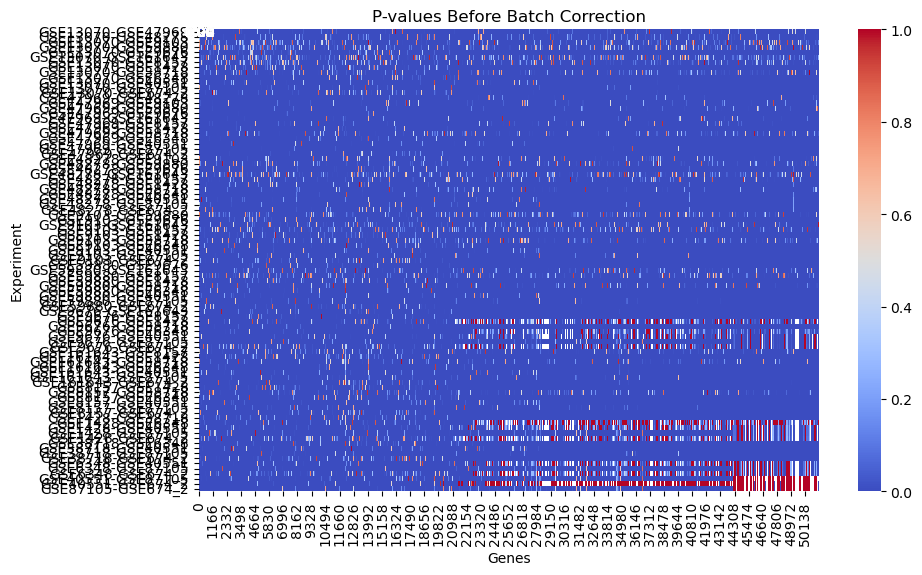

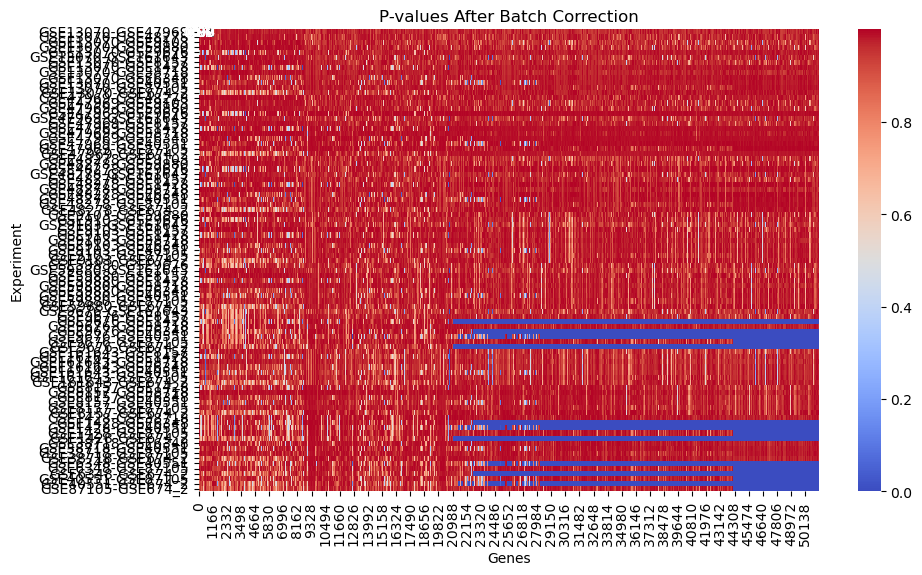

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists of p-values to a 2D NumPy array
p_values_before_array = np.array(expriments_pvalue_before)
p_values_after_array = np.array(expriments_pvalue_after)

# Create a heatmap for p-values before batch correction
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_before_array, cmap='coolwarm', annot=True, fmt=".2f", yticklabels=combination_list)
plt.title('P-values Before Batch Correction')
plt.xlabel('Genes')
plt.ylabel('Experiment')
plt.savefig(f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_reCombatheatmap_before_double_norm.png")
plt.show()

# Create a heatmap for p-values after batch correction
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_after_array, cmap='coolwarm', annot=True, fmt=".2f", yticklabels=combination_list)
plt.title('P-values After Batch Correction')
plt.xlabel('Genes')
plt.ylabel('Experiment')
plt.savefig(f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_reCombatheatmap_after_double_norm.png")
plt.show()

DE only in one experiment

In [51]:
import pandas as pd
experiment="GSE157585"

def get_columns_to_keep_one(experiment):
    # Path to the CSV file
    file_path = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment}_DDS.csv'
    
    # Read the CSV file
    de_genes = pd.read_csv(file_path, index_col=0)
    
    # Filter rows based on condition
    filtered_data = de_genes[(abs(de_genes['log2FoldChange']) > 1) & (de_genes['padj'] < 0.1)]
    
    # Extract column names from filtered data
    columns_to_keep = filtered_data["row"].str.strip().tolist()
    return columns_to_keep

# Assuming p_values_before is another DataFrame you want to filter columns from
# Replace p_values_before with your DataFrame name
#filtered_columns = p_values_before[columns_to_keep]

# Now you can work with the filtered columns DataFrame as needed


In [52]:
if technology =="RNAseq":
    columns_to_keep = get_columns_to_keep_one(experiment)

In [53]:
if technology =="RNAseq":
    len(columns_to_keep)

In [54]:
#filter_Bools = [(abs(de_genes['log2FoldChange']) > 1) & (de_genes['padj'] < 0.1)][0]

In [55]:
#p_values_after[x]

In [56]:
if technology =="RNAseq":

    DE_data = data.copy()
    DE_data_corrected = data_corrected.copy()
    
    DE_data= DE_data.T
    DE_data = DE_data[columns_to_keep]
    DE_data_corrected = DE_data_corrected[columns_to_keep]
    DE_data= DE_data.T
    
    p_values_before, p_values_after = get_p_values_before_after(DE_data, DE_data_corrected, experiment_1, experiment_2)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


In [57]:
if technology =="RNAseq":
    DE_data_corrected

In [58]:
if technology =="RNAseq":
    DE_data

In [59]:
if technology =="RNAseq":
    DE_data.columns

In [60]:
if technology =="RNAseq":

    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[columns_to_keep]
    group_b_samples_before = group_b_samples_before[columns_to_keep]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[columns_to_keep]
    group_b_samples_corrected = group_b_samples_corrected[columns_to_keep]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


# Cluster data before and after

In [61]:
metadata_short =  pd.DataFrame({
    'Experiment': experiment_order,
    'Age': age_order,
    'Sample': sample_order
})
metadata_short.set_index('Sample', inplace=True)
metadata_short

,Experiment,Age
Sample,,
GSM342608,GSE13070,MiddleAge
GSM342609,GSE13070,MiddleAge
GSM342610,GSE13070,MiddleAge
GSM342611,GSE13070,MiddleAge
GSM342614,GSE13070,MiddleAge
...,...,...
GSM244612,GSE9676,Old
GSM244613,GSE9676,Old
GSM244614,GSE9676,Old


In [62]:
data_corrected.index = cts["Sample"]
cts_processed.index = cts["Sample"]

In [63]:
adjuested_data_full = pd.concat([data_corrected, metadata_short], axis=1)

In [64]:
unadjested_data_full= pd.concat([cts_processed, metadata_short], axis=1)

In [65]:
adjuested_data_full.columns[10:]

Index(['X75208', 'L38487', 'M33318', 'NM_005505', 'NM_015140', 'NM_052871',
       'NM_080735', 'NM_138957', 'NM_145004', 'NM_138796',
       ...
       'W22117', 'AI028241', 'AI571298', 'AA149545', 'C18318', 'AI219073',
       'AI205180', 'AI363375', 'Experiment', 'Age'],
      dtype='object', length=51268)

In [66]:
cts_2 = cts.set_index("Sample")
cts_2

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Sex,Age,Status
Sample,,,,,,,,,,,,,,,,,,,,,
GSM342608,870.599976,500.399994,165.000000,900.900024,67.400002,346.600006,255.300003,58.000000,70.800003,168.000000,...,341.000000,2384.300049,101.699997,59.500000,159.399994,233.000000,GSE13070,Male,52.50,IRd
GSM342609,1635.300049,390.899994,252.199997,795.000000,108.300003,623.000000,260.500000,76.400002,4.200000,191.600006,...,292.399994,3852.000000,70.699997,32.700001,155.899994,383.200012,GSE13070,Male,50.60,IRd
GSM342610,1006.799988,383.200012,198.199997,924.000000,129.399994,649.599976,192.800003,40.700001,16.200001,65.500000,...,263.799988,2043.599976,165.000000,94.099998,220.100006,399.100006,GSE13070,Male,56.08,IRd � TZD
GSM342611,1215.800049,496.200012,160.600006,500.899994,18.799999,345.299988,257.600006,23.400000,41.500000,127.199997,...,238.100006,2176.800049,93.599998,21.799999,183.899994,483.899994,GSE13070,Male,54.84,IRd � TZD
GSM342614,823.599976,561.500000,305.500000,1214.099976,81.300003,494.399994,208.199997,63.799999,79.199997,145.000000,...,223.899994,2341.699951,142.600006,79.699997,341.299988,397.399994,GSE13070,Male,51.14,IRd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,1316.250000,1582.450000,11268.600000,7065.080000,6376.640000,1996.200000,10128.300000,7015.010000,235.884000,2498.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.10,NaN
GSM244613,966.504000,889.863000,9753.840000,4753.410000,6072.460000,1229.210000,6264.000000,5658.760000,335.332000,1764.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,68.40,NaN
GSM244614,1382.900000,1278.390000,11248.800000,7119.220000,6891.120000,1431.700000,8131.630000,6416.350000,432.760000,2197.460000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GSE9676,Female,65.90,NaN


In [67]:
adjuested_data_full["Age"]=cts_2["Age"]

adjuested_data_full

,U48705,M87338,X51757,X69699,L36861,L13852,X55005,X79510,M21121,J02843,...,W22117,AI028241,AI571298,AA149545,C18318,AI219073,AI205180,AI363375,Experiment,Age
Sample,,,,,,,,,,,,,,,,,,,,,
GSM342608,-0.936345,0.015225,-0.028562,-0.019885,0.006741,-0.435788,-0.013205,-0.042681,0.001134,0.077323,...,-0.778901,-0.755246,0.417180,-0.383551,0.309619,-0.000230,-0.836801,-1.325908,GSE13070,52.50
GSM342609,0.516161,-0.360085,0.031108,-0.089836,0.060816,0.943246,0.000147,-0.015349,-0.562068,0.196182,...,1.074347,0.412788,0.089997,1.396052,-0.265240,-0.563873,-0.820670,0.330207,GSE13070,50.60
GSM342610,-0.670909,-0.436229,-0.006424,0.018364,0.082632,0.987415,-0.060334,-0.063517,-0.459591,-0.297833,...,-0.562157,0.610976,-0.252021,-0.716328,1.673020,0.804256,-0.534760,0.384888,GSE13070,56.08
GSM342611,-0.242927,0.088927,-0.026856,-0.394352,-0.049742,-0.371358,-0.002177,-0.084742,-0.231531,-0.052484,...,2.140038,0.265120,-0.430561,-0.502683,0.229212,-0.816870,-0.683112,1.373652,GSE13070,54.84
GSM342614,-1.095967,0.139090,0.046489,0.224945,0.017923,0.111814,-0.059706,-0.039783,0.035643,-0.037101,...,-0.936273,0.216959,-0.772001,-0.568819,0.992813,0.352083,-0.070993,0.086777,GSE13070,51.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM244612,1.409118,0.642580,-0.390609,0.210783,0.367824,2.934954,0.886791,1.740655,-1.543886,2.465915,...,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385,GSE9676,65.10
GSM244613,-0.863118,-2.029984,-0.785770,-1.249532,0.707690,-0.236247,-1.335429,0.486263,-0.889848,0.311594,...,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385,GSE9676,68.40
GSM244614,1.686705,-0.833622,-0.591422,0.112096,0.802670,0.011357,-0.607074,0.583635,-0.615088,1.113347,...,-0.000422,-0.001676,-0.001017,-0.000629,-0.001254,-0.001076,-0.001416,-0.001385,GSE9676,65.90


In [68]:
adjuested_data_full.to_csv(f"/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/{technology}_abundances_adjusted_recombat_double_norm.csv")

In [69]:
#unadjested_data_full.to_csv(f"/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/{technology}_All_abundances_unadjusted_2_recombat.csv")

Looking at reCombat plotting

In [70]:
X = data_corrected.fillna(0, inplace=False).values 

In [71]:
X

array([[-9.36344543e-01,  1.52249455e-02, -2.85616553e-02, ...,
        -2.29701701e-04, -8.36800627e-01, -1.32590754e+00],
       [ 5.16161231e-01, -3.60084530e-01,  3.11083446e-02, ...,
        -5.63873255e-01, -8.20669545e-01,  3.30206981e-01],
       [-6.70908793e-01, -4.36229423e-01, -6.42379400e-03, ...,
         8.04256078e-01, -5.34759580e-01,  3.84888179e-01],
       ...,
       [ 1.68670451e+00, -8.33621883e-01, -5.91421552e-01, ...,
        -1.07589322e-03, -1.41640103e-03, -1.38494074e-03],
       [ 1.37947426e+00, -1.39414599e+00, -1.48610542e+00, ...,
        -1.07589322e-03, -1.41640103e-03, -1.38494074e-03],
       [-1.36127567e-01, -7.63681416e-01, -3.53432926e-01, ...,
        -1.07589322e-03, -1.41640103e-03, -1.38494074e-03]])

In [72]:

# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(experiment_order)}
if technology =="RNAseq":
    category_map = {'GSE164471': -1, 'GSE152558': 0, 'GSE157585': 1, 'GSE167186':2, "GSE60590":3, "GSE129643":4}
elif technology == "microarray":
    category_map = {'GSE13070':-6, 'GSE47969':-5, 'GSE48278':-4, 'GSE9103':-3, 'GSE59880':-2, 'GSE9676':-1, 'GSE161643':0, 'GSE8157':1, 'GSE1428':2, 'GSE38718':3, 'GSE6348':4, 'GSE40551':5, 'GSE87105':6, 'GSE674_2':7}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_experiment_order = [category_map[experiment] for experiment in experiment_order]

from matplotlib.colors import ListedColormap
tab20_colors = plt.cm.tab20.colors
num_colors = len(np.unique(experiment_order))
colors = [tab20_colors[i] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)


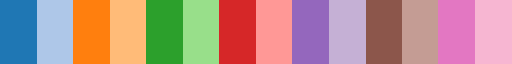

In [73]:
custom_cmap

Using tSNE


In [74]:
from sklearn.manifold import TSNE
X = data_corrected.values 
tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(X)
# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
x=tSNE_result[:,0]
y=tSNE_result[:,1]

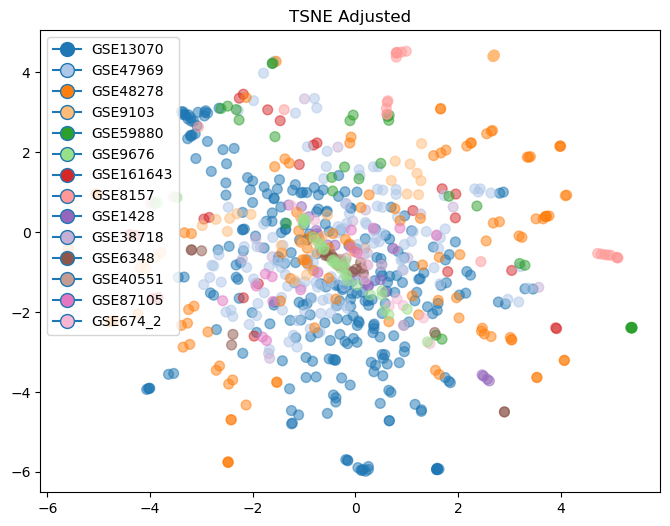

In [75]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Adjusted')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_reCombat_by_experiment_double_norm.png"
plt.savefig(save)

Using PCA

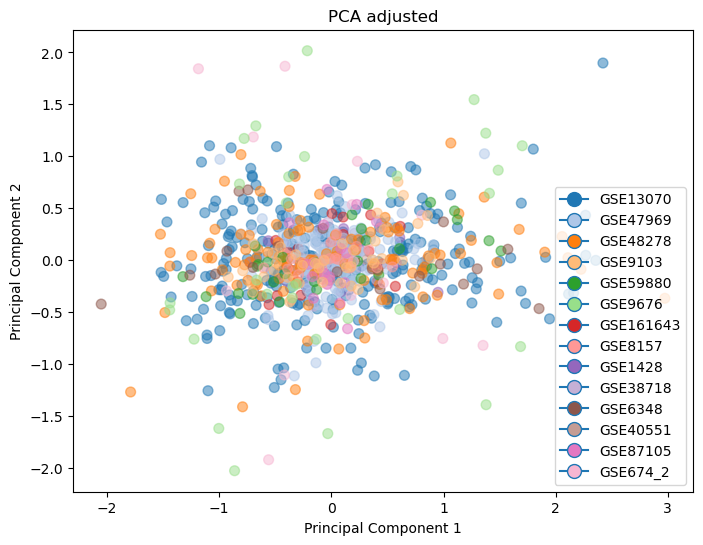

In [76]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA adjusted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_reCombat_by_experiment_double_norm.png"
plt.savefig(save)

Lookign at the age

In [77]:



# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(age_order)}
category_map = {'Young': -1,  'MiddleAge': 0, 'Old': 1}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_age_order = [category_map[experiment] for experiment in age_order]
tab20_colors = plt.cm.tab10.colors
num_colors = len(np.unique(age_order))
colors = [tab20_colors[i] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)


In [78]:
pd.DataFrame(age_order).value_counts()

MiddleAge    571
Young        128
Old           78
Name: count, dtype: int64

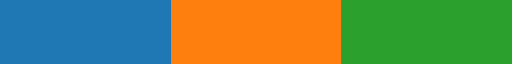

In [79]:
custom_cmap

tSNE

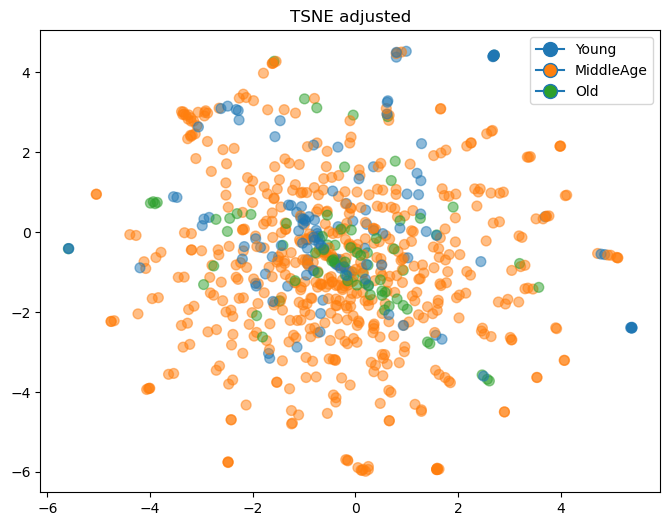

In [80]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE adjusted')

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_reCombat_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Age_reCombat.jpg")

PCA

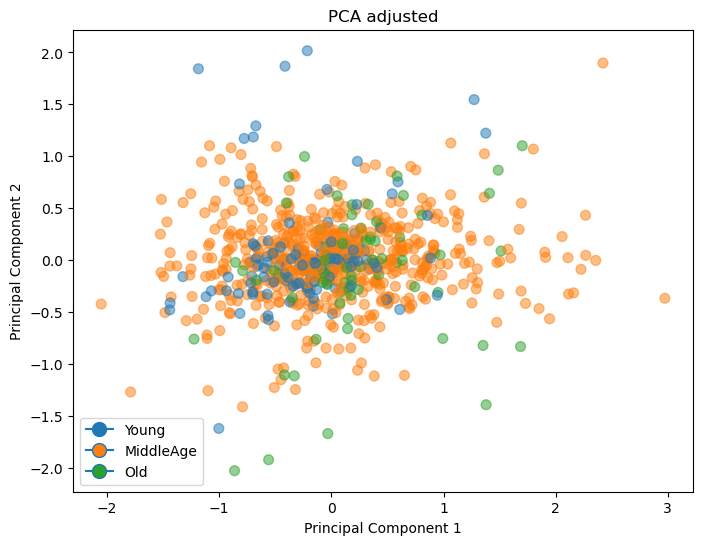

In [81]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA adjusted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_reCombat_by_age_Double_norm.png"
plt.savefig(save)
# plt.savefig("PCA_Scatter_Plot_Age_reCombat.jpg")

# Unadjusted

In [82]:
X = cts_processed.values 


tSNE by experiment

In [83]:

tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(X)
# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
x=tSNE_result[:,0]
y=tSNE_result[:,1]

In [84]:
# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(experiment_order)}
if technology =="RNAseq":
    category_map = {'GSE164471': -1, 'GSE152558': 0, 'GSE157585': 1, 'GSE167186':2, "GSE60590":3, "GSE129643":4}
elif technology == "microarray":
    category_map = {'GSE13070':-6, 'GSE47969':-5, 'GSE48278':-4, 'GSE9103':-3, 'GSE59880':-2, 'GSE9676':-1, 'GSE161643':0, 'GSE8157':1, 'GSE1428':2, 'GSE38718':3, 'GSE6348':4, 'GSE40551':5, 'GSE87105':6, 'GSE674_2':7}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_experiment_order = [category_map[experiment] for experiment in experiment_order]

from matplotlib.colors import ListedColormap
tab20_colors = plt.cm.tab20.colors
num_colors = len(np.unique(experiment_order))
colors = [tab20_colors[i ] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)

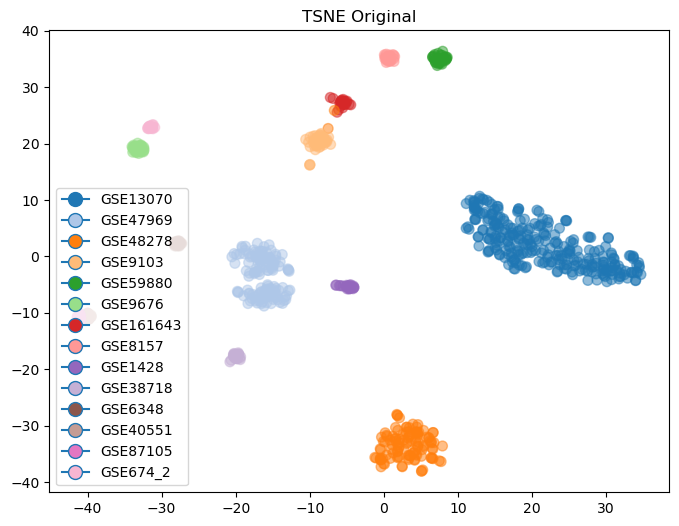

In [85]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Original')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Original_by_experiment_reCombat_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Experiment_Original.jpg")

PCA by experiment original

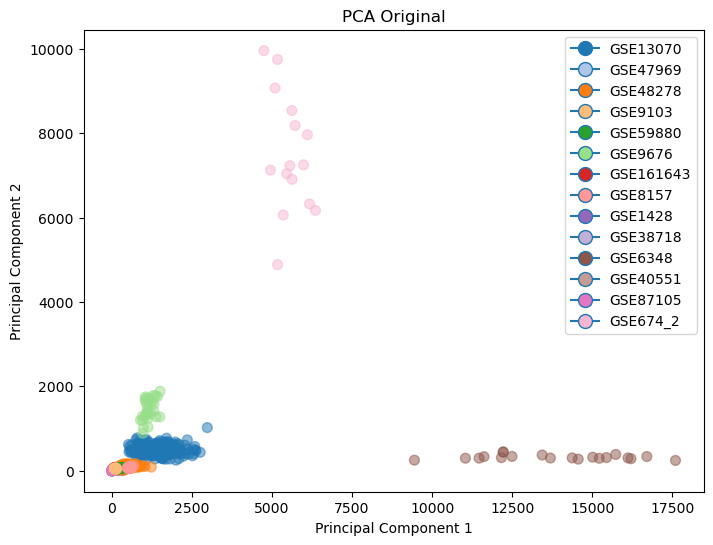

In [86]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA Original')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Original_by_experiment_reCombat_double_norm.png"
plt.savefig(save)
#plt.savefig("PCA_Scatter_Plot_Experiment_Original.jpg")

By age

In [87]:

# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(age_order)}
category_map = {'Young': -1,  'MiddleAge': 0, 'Old': 1}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_age_order = [category_map[experiment] for experiment in age_order]
tab20_colors = plt.cm.tab10.colors
num_colors = len(np.unique(age_order))
colors = [tab20_colors[i % 20] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)

TSNE by age

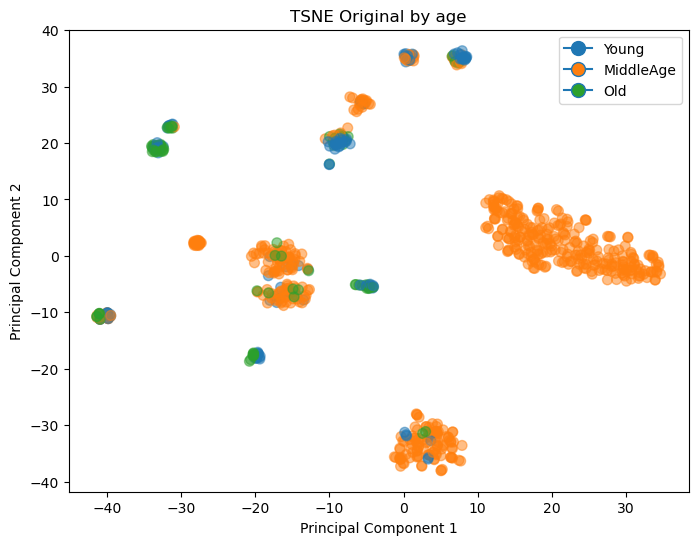

In [88]:


# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Original by age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Original_by_age_reCombat_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Age_Original.jpg")

PCA by age original

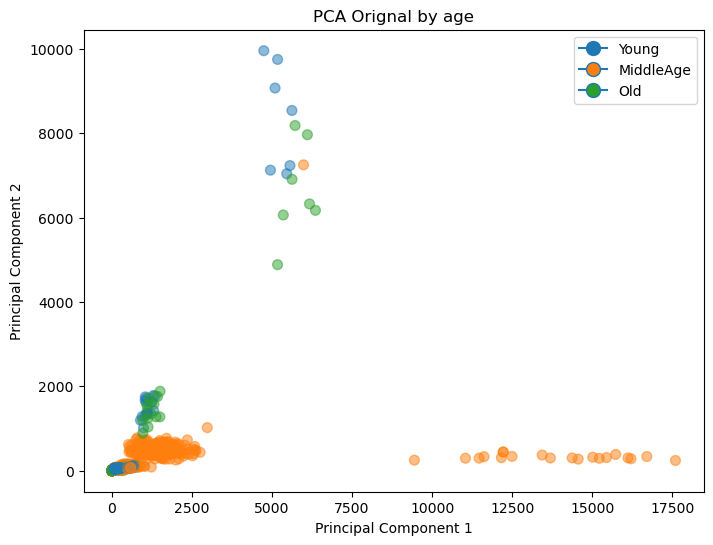

In [89]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA Orignal by age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Original_by_age_reCombat_double_norm.png"
plt.savefig(save)
#plt.savefig("PCA_Scatter_Plot_Age_Original.jpg")

UMAP